In [ ]:
# 📊 E-Commerce Data Analysis: Top 100 Products
## Phân Tích Độ Tin Cậy và Khả Năng Bán Hàng

**Mục tiêu:**
- Sử dụng **K-Means Clustering** để phân nhóm sản phẩm
- Sử dụng **Linear Regression** để dự đoán khả năng bán hàng
- Đánh giá độ tin cậy dựa trên reviews và ratings
- Visualize với biểu đồ và bảng thống kê chi tiết

# 📊 E-Commerce Data Analysis: Top 100 Products
## Phân Tích Độ Tin Cậy và Khả Năng Bán Hàng

**Mục tiêu:**
- Sử dụng **K-Means Clustering** để phân nhóm sản phẩm
- Sử dụng **Linear Regression** để dự đoán khả năng bán hàng
- Đánh giá độ tin cậy dựa trên reviews và ratings
- Visualize với biểu đồ và bảng thống kê chi tiết

## 1. Import Libraries và Load Data

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Import libraries thành công!")

✅ Import libraries thành công!


In [2]:
# Load dữ liệu products và reviews
products_df = pd.read_csv('src/scraping/extracted_products.csv')
reviews_df = pd.read_csv('src/scraping/product_reviews.csv')

print("📊 THÔNG TIN DỮ LIỆU")
print("="*60)
print(f"Tổng số sản phẩm: {len(products_df):,}")
print(f"Tổng số reviews: {len(reviews_df):,}")
print(f"\nColumns trong products: {list(products_df.columns)}")
print(f"\nColumns trong reviews: {list(reviews_df.columns)}")
print("\n" + "="*60)
print("\n🔍 Preview Products:")
display(products_df.head())
print("\n🔍 Preview Reviews:")
display(reviews_df.head())

📊 THÔNG TIN DỮ LIỆU
Tổng số sản phẩm: 16,980
Tổng số reviews: 31,216

Columns trong products: ['id', 'name', 'price', 'original_price', 'discount', 'rating', 'quantity_sold', 'specifications', 'stock_item', 'brand_name']

Columns trong reviews: ['product_id', 'review_id', 'title', 'content', 'rating', 'author', 'time', 'helpful_count']


🔍 Preview Products:


,id,name,price,original_price,discount,rating,quantity_sold,specifications,stock_item,brand_name
0,278905095,Điện Thoại Realme Note 60x 4GB/64GB - Hàng Chí...,1990000,2490000,20,0.0,0,"[{'name': 'Thương hiệu', 'value': 'Realme'}, {...","{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...",Realme
1,276062770,Điện Thoại Xiaomi Redmi 14C 4GB/128GB - Hàng C...,2499000,3290000,24,0.0,2,"[{'name': 'Bluetooth', 'value': 'Bluetooth 5.0...","{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...",Xiaomi
2,278609733,Điện thoại POCO C85 (6GB/128GB) - Hàng Chính Hãng,2690000,2990000,10,0.0,0,"[{'name': 'Thương hiệu', 'value': 'POCO'}, {'n...","{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...",POCO
3,277944334,Điện Thoại Samsung Galaxy A06 5G 4GB/64GB - Hà...,2469000,3490000,29,5.0,3,"[{'name': 'Dung lượng pin', 'value': '5000mAh'...","{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...",Samsung
4,277737595,Điện Thoại Samsung Galaxy A06 5G 4GB/128GB - H...,2749000,4490000,39,4.8,16,"[{'name': 'Dung lượng pin', 'value': '5000mAH'...","{'max_sale_qty': 1000, 'min_sale_qty': 1, 'pre...",Samsung



🔍 Preview Reviews:


,product_id,review_id,title,content,rating,author,time,helpful_count
0,277944334,20171597,Cực kì hài lòng,nói chung với tầm giá đó thì rất hời rồi. Học ...,5,Nguyễn Bá Hùng,1758166281,0
1,277737595,20174536,Cực kì hài lòng,Nhan vien giao hàng k than thien. Toi de nghi ...,5,vo tran chi,1758861803,0
2,277737595,20182803,Cực kì hài lòng,"Ngon bổ rẻ, cám ơm shop, nếu có cơ hội sẽ ủng ...",5,Vo Dai Nghia,1760791470,0
3,277737595,20173329,Cực kì hài lòng,"hàng chính hãng, nguyên seal.",5,Tran Quang,1758549075,0
4,277737595,20158981,Cực kì hài lòng,"Điện thoại sài mượt , hàng nguyên siêu , đóng ...",5,Nguyễn Vương Linh,1755238026,0


## 2. Data Preprocessing và Feature Engineering

In [3]:
# Tính toán các metrics cho reviews
review_stats = reviews_df.groupby('product_id').agg({
    'review_id': 'count',
    'rating': ['mean', 'std'],
    'helpful_count': 'sum'
}).reset_index()

review_stats.columns = ['product_id', 'review_count', 'avg_rating_from_reviews', 'rating_std', 'total_helpful']

# Merge với products data
df = products_df.merge(review_stats, left_on='id', right_on='product_id', how='left')

# Fill NaN values
df['review_count'] = df['review_count'].fillna(0)
df['avg_rating_from_reviews'] = df['avg_rating_from_reviews'].fillna(df['rating'])
df['rating_std'] = df['rating_std'].fillna(0)
df['total_helpful'] = df['total_helpful'].fillna(0)

# Tạo các features mới
df['discount_amount'] = df['original_price'] - df['price']
df['discount_percentage'] = df['discount']
df['has_reviews'] = (df['review_count'] > 0).astype(int)
df['rating_reliability'] = df['rating'] * np.log1p(df['review_count'])  # Độ tin cậy = rating * log(số reviews)
df['sales_potential'] = df['quantity_sold'] * df['price']  # Tiềm năng bán hàng
df['engagement_score'] = df['review_count'] + df['total_helpful']  # Điểm tương tác

print("✅ Feature Engineering hoàn thành!")
print(f"\n📊 Dataset shape: {df.shape}")
print(f"\nNew features created:")
print("  - discount_amount: Số tiền giảm giá")
print("  - rating_reliability: Độ tin cậy rating (rating × log(reviews))")
print("  - sales_potential: Tiềm năng bán (quantity_sold × price)")
print("  - engagement_score: Điểm tương tác (reviews + helpful)")
display(df[['name', 'rating', 'review_count', 'rating_reliability', 'sales_potential', 'engagement_score']].head(10))

✅ Feature Engineering hoàn thành!

📊 Dataset shape: (16980, 21)

New features created:
  - discount_amount: Số tiền giảm giá
  - rating_reliability: Độ tin cậy rating (rating × log(reviews))
  - sales_potential: Tiềm năng bán (quantity_sold × price)
  - engagement_score: Điểm tương tác (reviews + helpful)


,name,rating,review_count,rating_reliability,sales_potential,engagement_score
0,Điện Thoại Realme Note 60x 4GB/64GB - Hàng Chí...,0.0,0.0,0.000000,0,0.0
1,Điện Thoại Xiaomi Redmi 14C 4GB/128GB - Hàng C...,0.0,0.0,0.000000,4998000,0.0
2,Điện thoại POCO C85 (6GB/128GB) - Hàng Chính Hãng,0.0,0.0,0.000000,0,0.0
3,Điện Thoại Samsung Galaxy A06 5G 4GB/64GB - Hà...,5.0,40.0,18.567860,7407000,40.0
4,Điện Thoại Samsung Galaxy A06 5G 4GB/128GB - H...,4.8,312.0,27.581775,43984000,312.0
5,Điện Thoại Realme Note 60x 4GB/64GB - Hàng Chí...,0.0,0.0,0.000000,0,0.0
6,Điện Thoại Xiaomi Redmi 14C 4GB/128GB - Hàng C...,0.0,0.0,0.000000,4998000,0.0
7,Điện thoại POCO C85 (6GB/128GB) - Hàng Chính Hãng,0.0,0.0,0.000000,0,0.0
8,Điện Thoại Samsung Galaxy A06 5G 4GB/64GB - Hà...,5.0,40.0,18.567860,7407000,40.0
9,Điện Thoại Samsung Galaxy A06 5G 4GB/128GB - H...,4.8,312.0,27.581775,43984000,312.0


In [4]:
# Chọn top 100 sản phẩm tốt nhất dựa trên sales_potential và rating_reliability
df['combined_score'] = (
    df['sales_potential'] / df['sales_potential'].max() * 0.4 +
    df['rating_reliability'] / df['rating_reliability'].max() * 0.3 +
    df['engagement_score'] / df['engagement_score'].max() * 0.3
)

top_100 = df.nlargest(100, 'combined_score').copy()

print("🏆 TOP 100 SẢN PHẨM TỐT NHẤT")
print("="*80)
print(f"Số lượng sản phẩm: {len(top_100)}")
print(f"\nThống kê cơ bản:")
print(top_100[['price', 'rating', 'quantity_sold', 'review_count', 'rating_reliability', 'sales_potential']].describe())
print("\n" + "="*80)
print("\n📋 Top 10 sản phẩm:")
display(top_100[['name', 'brand_name', 'price', 'rating', 'quantity_sold', 'review_count', 'combined_score']].head(10))

🏆 TOP 100 SẢN PHẨM TỐT NHẤT
Số lượng sản phẩm: 100

Thống kê cơ bản:
              price      rating  quantity_sold  review_count  \
count  1.000000e+02  100.000000     100.000000    100.000000   
mean   2.835186e+06    4.676000    2416.940000    861.360000   
std    1.716523e+06    0.112923    7021.409152    456.737741   
min    1.448000e+05    4.300000     167.000000    120.000000   
25%    3.890000e+05    4.600000     167.000000    340.000000   
50%    3.990000e+06    4.700000     167.000000   1220.000000   
75%    3.990000e+06    4.700000    1284.000000   1220.000000   
max    4.090000e+06    5.000000   29923.000000   1220.000000   

       rating_reliability  sales_potential  
count          100.000000     1.000000e+02  
mean            30.531810     7.891158e+09  
std              3.674871     2.907250e+10  
min             23.978953     2.919168e+08  
25%             26.826659     4.994760e+08  
50%             33.404900     6.663300e+08  
75%             33.404900     6.663300e

,name,brand_name,price,rating,quantity_sold,review_count,combined_score
2376,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,OPPO,4090000,5.0,29923,120.0,0.641804
2416,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,OPPO,4090000,5.0,29923,120.0,0.641804
2524,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,OPPO,4090000,5.0,29923,120.0,0.641804
2554,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,OPPO,4090000,5.0,29923,120.0,0.641804
2589,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,OPPO,4090000,5.0,29923,120.0,0.641804
2629,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,OPPO,4090000,5.0,29923,120.0,0.641804
104,Điện thoại Xiaomi Redmi Note 10 JE 5G 4GB/64GB...,Xiaomi,3990000,4.7,167,1220.0,0.602178
134,Điện thoại Xiaomi Redmi Note 10 JE 5G 4GB/64GB...,Xiaomi,3990000,4.7,167,1220.0,0.602178
169,Điện thoại Xiaomi Redmi Note 10 JE 5G 4GB/64GB...,Xiaomi,3990000,4.7,167,1220.0,0.602178
209,Điện thoại Xiaomi Redmi Note 10 JE 5G 4GB/64GB...,Xiaomi,3990000,4.7,167,1220.0,0.602178


## 3. K-Means Clustering - Phân Nhóm Sản Phẩm

In [6]:
# Fix for OpenBLAS/threadpoolctl issue on macOS
import threadpoolctl
from unittest.mock import MagicMock

# Monkey-patch threadpoolctl to avoid the OpenBLAS issue
original_threadpool_info = threadpoolctl.threadpool_info

def patched_threadpool_info():
    try:
        return original_threadpool_info()
    except AttributeError:
        # Return empty list if there's an AttributeError
        return []

threadpoolctl.threadpool_info = patched_threadpool_info

print("✅ Applied threadpoolctl patch for macOS compatibility")

✅ Applied threadpoolctl patch for macOS compatibility


🔍 PHÂN TÍCH DỰA TRÊN 3 BIẾN CHÍNH
📌 Biến độc lập (dùng để phân cụm):
   1. price
   2. quantity_sold
   3. discount_percentage

📊 Biến phụ thuộc (phân tích sau khi phân cụm):
   1. rating
   2. review_count
   3. rating_reliability
   4. engagement_score


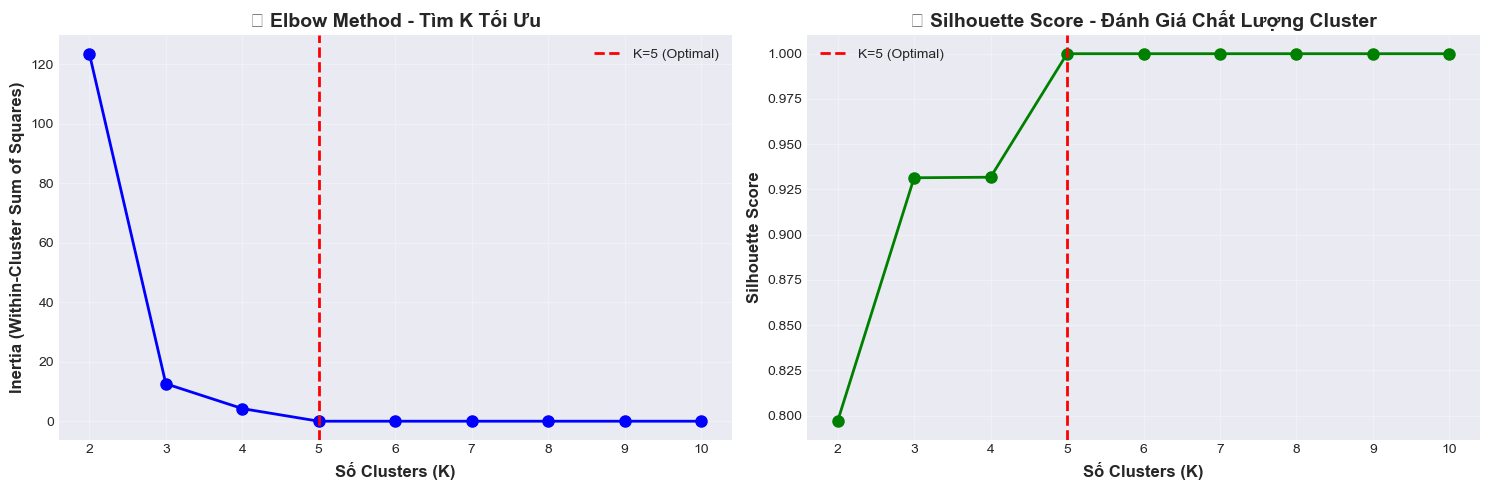


✅ Best K based on Silhouette Score: 5
   Max Silhouette Score: 1.0000


In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHÂN TÍCH MỚI: Sử dụng GIÁ CẢ, LƯỢT BÁN, TỈ LỆ GIẢM GIÁ làm biến chính
# ═══════════════════════════════════════════════════════════════════════════════

# Chuẩn bị features cho K-Means - CHỈ SỬ DỤNG 3 BIẾN CHÍNH
primary_features = ['price', 'quantity_sold', 'discount_percentage']

# Các biến phụ thuộc để phân tích sau
dependent_features = ['rating', 'review_count', 'rating_reliability', 'engagement_score']

X_cluster = top_100[primary_features].copy()

print("🔍 PHÂN TÍCH DỰA TRÊN 3 BIẾN CHÍNH")
print("="*80)
print("📌 Biến độc lập (dùng để phân cụm):")
for i, feature in enumerate(primary_features, 1):
    print(f"   {i}. {feature}")
print("\n📊 Biến phụ thuộc (phân tích sau khi phân cụm):")
for i, feature in enumerate(dependent_features, 1):
    print(f"   {i}. {feature}")
print("="*80)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Tìm số cluster tối ưu bằng Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Vẽ Elbow Curve và Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Số Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
axes[0].set_title('📊 Elbow Method - Tìm K Tối Ưu', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Tìm optimal K
optimal_k_idx = np.argmax(silhouette_scores)
optimal_k_value = K_range[optimal_k_idx]
axes[0].axvline(x=optimal_k_value, color='red', linestyle='--', label=f'K={optimal_k_value} (Optimal)', linewidth=2)
axes[0].legend()

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Số Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('📊 Silhouette Score - Đánh Giá Chất Lượng Cluster', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=optimal_k_value, color='red', linestyle='--', label=f'K={optimal_k_value} (Optimal)', linewidth=2)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Best K based on Silhouette Score: {optimal_k_value}")
print(f"   Max Silhouette Score: {max(silhouette_scores):.4f}")

In [17]:
# Apply K-Means với K tối ưu
optimal_k = K_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
top_100['cluster'] = kmeans.fit_predict(X_scaled)

# Thống kê chi tiết các cluster - BẢN MỞ RỘNG
print("📊 THỐNG KÊ CHI TIẾT CÁC CLUSTER")
print("="*120)

# Thống kê biến chính (dùng để phân cụm)
cluster_primary_stats = top_100.groupby('cluster').agg({
    'price': ['mean', 'std', 'min', 'max'],
    'quantity_sold': ['sum', 'mean', 'std', 'max'],
    'discount_percentage': ['mean', 'std', 'min', 'max'],
    'id': 'count'
}).round(2)

cluster_primary_stats.columns = ['_'.join(col).strip() for col in cluster_primary_stats.columns.values]
cluster_primary_stats = cluster_primary_stats.rename(columns={'id_count': 'product_count'})

print("\n🎯 BIẾN CHÍNH (Dùng để phân cụm):")
print("-"*120)
display(cluster_primary_stats)

# Thống kê biến phụ thuộc
cluster_dependent_stats = top_100.groupby('cluster').agg({
    'rating': ['mean', 'std', 'min', 'max'],
    'review_count': ['sum', 'mean', 'max'],
    'rating_reliability': ['mean', 'std', 'min', 'max'],
    'engagement_score': ['sum', 'mean', 'max']
}).round(2)

cluster_dependent_stats.columns = ['_'.join(col).strip() for col in cluster_dependent_stats.columns.values]

print("\n📊 BIẾN PHỤ THUỘC (Phân tích sau khi phân cụm):")
print("-"*120)
display(cluster_dependent_stats)

print("\n" + "="*120)

📊 THỐNG KÊ CHI TIẾT CÁC CLUSTER

🎯 BIẾN CHÍNH (Dùng để phân cụm):
------------------------------------------------------------------------------------------------------------------------


,price_mean,price_std,price_min,price_max,quantity_sold_sum,quantity_sold_mean,quantity_sold_std,quantity_sold_max,discount_percentage_mean,discount_percentage_std,discount_percentage_min,discount_percentage_max,product_count
cluster,,,,,,,,,,,,,
0,3990000.0,0.0,3990000,3990000,10187,167.0,0.0,167,0.0,0.0,0,0,61
1,389000.0,0.0,389000,389000,16692,1284.0,0.0,1284,29.0,0.0,29,29,13
2,4090000.0,0.0,4090000,4090000,179538,29923.0,0.0,29923,18.0,0.0,18,18,6
3,144800.0,0.0,144800,144800,34272,2016.0,0.0,2016,20.0,0.0,20,20,17
4,2690000.0,0.0,2690000,2690000,1005,335.0,0.0,335,36.0,0.0,36,36,3



📊 BIẾN PHỤ THUỘC (Phân tích sau khi phân cụm):
------------------------------------------------------------------------------------------------------------------------


,rating_mean,rating_std,rating_min,rating_max,review_count_sum,review_count_mean,review_count_max,rating_reliability_mean,rating_reliability_std,rating_reliability_min,rating_reliability_max,engagement_score_sum,engagement_score_mean,engagement_score_max
cluster,,,,,,,,,,,,,,
0,4.7,0.0,4.7,4.7,74420.0,1220.0,1220.0,33.40,0.0,33.40,33.40,107909.0,1769.0,1769.0
1,4.6,0.0,4.6,4.6,3380.0,260.0,260.0,25.60,0.0,25.60,25.60,9971.0,767.0,767.0
2,5.0,0.0,5.0,5.0,720.0,120.0,120.0,23.98,0.0,23.98,23.98,936.0,156.0,156.0
3,4.6,0.0,4.6,4.6,5780.0,340.0,340.0,26.83,0.0,26.83,26.83,15028.0,884.0,884.0
4,4.3,0.0,4.3,4.3,1836.0,612.0,612.0,27.60,0.0,27.60,27.60,1836.0,612.0,612.0


In [18]:
# Phân tích và đặt tên cho các cluster dựa trên 3 biến chính
cluster_names = {}

print("\n🏷️  PHÂN TÍCH VÀ ĐẶT TÊN CÁC CLUSTER")
print("="*100)

for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    
    # Phân tích đặc điểm cluster dựa trên 3 biến chính
    avg_price = cluster_data['price'].mean()
    avg_quantity = cluster_data['quantity_sold'].mean()
    avg_discount = cluster_data['discount_percentage'].mean()
    total_quantity = cluster_data['quantity_sold'].sum()
    count = len(cluster_data)
    
    # Phân tích biến phụ thuộc
    avg_rating = cluster_data['rating'].mean()
    avg_reviews = cluster_data['review_count'].mean()
    avg_reliability = cluster_data['rating_reliability'].mean()
    avg_engagement = cluster_data['engagement_score'].mean()
    
    # Xác định tên cluster dựa trên đặc điểm
    price_level = "Cao" if avg_price > top_100['price'].quantile(0.66) else "Thấp" if avg_price < top_100['price'].quantile(0.33) else "Trung Bình"
    sales_level = "Bán Chạy" if avg_quantity > top_100['quantity_sold'].quantile(0.66) else "Ít Bán" if avg_quantity < top_100['quantity_sold'].quantile(0.33) else "TB"
    discount_level = "Giảm Mạnh" if avg_discount > top_100['discount_percentage'].quantile(0.66) else "Ít Giảm" if avg_discount < top_100['discount_percentage'].quantile(0.33) else "Giảm Vừa"
    
    # Tạo tên cluster
    cluster_name = f"{price_level} - {sales_level} - {discount_level}"
    cluster_names[cluster_id] = cluster_name
    
    print(f"\n🔹 Cluster {cluster_id}: {cluster_name}")
    print(f"   📦 Số sản phẩm: {count}")
    print(f"   💰 Giá trung bình: {avg_price:,.0f} VNĐ")
    print(f"   📊 Lượt bán TB: {avg_quantity:.0f} (Tổng: {total_quantity:,.0f})")
    print(f"   🎯 Giảm giá TB: {avg_discount:.1f}%")
    print(f"   ⭐ Rating TB: {avg_rating:.2f} | Reviews TB: {avg_reviews:.0f}")
    print(f"   📈 Độ tin cậy TB: {avg_reliability:.2f} | Engagement TB: {avg_engagement:.0f}")

top_100['cluster_name'] = top_100['cluster'].map(cluster_names)

print("\n" + "="*100)
print("\n✅ Đã gán tên cho tất cả các cluster!")


🏷️  PHÂN TÍCH VÀ ĐẶT TÊN CÁC CLUSTER

🔹 Cluster 0: Trung Bình - TB - Giảm Vừa
   📦 Số sản phẩm: 61
   💰 Giá trung bình: 3,990,000 VNĐ
   📊 Lượt bán TB: 167 (Tổng: 10,187)
   🎯 Giảm giá TB: 0.0%
   ⭐ Rating TB: 4.70 | Reviews TB: 1220
   📈 Độ tin cậy TB: 33.40 | Engagement TB: 1769

🔹 Cluster 1: Thấp - TB - Giảm Mạnh
   📦 Số sản phẩm: 13
   💰 Giá trung bình: 389,000 VNĐ
   📊 Lượt bán TB: 1284 (Tổng: 16,692)
   🎯 Giảm giá TB: 29.0%
   ⭐ Rating TB: 4.60 | Reviews TB: 260
   📈 Độ tin cậy TB: 25.60 | Engagement TB: 767

🔹 Cluster 2: Cao - Bán Chạy - Giảm Vừa
   📦 Số sản phẩm: 6
   💰 Giá trung bình: 4,090,000 VNĐ
   📊 Lượt bán TB: 29923 (Tổng: 179,538)
   🎯 Giảm giá TB: 18.0%
   ⭐ Rating TB: 5.00 | Reviews TB: 120
   📈 Độ tin cậy TB: 23.98 | Engagement TB: 156

🔹 Cluster 3: Thấp - Bán Chạy - Giảm Mạnh
   📦 Số sản phẩm: 17
   💰 Giá trung bình: 144,800 VNĐ
   📊 Lượt bán TB: 2016 (Tổng: 34,272)
   🎯 Giảm giá TB: 20.0%
   ⭐ Rating TB: 4.60 | Reviews TB: 340
   📈 Độ tin cậy TB: 26.83 | Engagemen

In [ ]:
# Visualize Clusters - Tập trung vào 3 biến chính và mối quan hệ với biến phụ thuộc
fig = plt.figure(figsize=(20, 14))

# ═══════════════ PHẦN 1: BIẾN CHÍNH (3 biểu đồ) ═══════════════

# 1. Scatter: Price vs Quantity Sold (2 BIẾN CHÍNH)
ax1 = plt.subplot(3, 3, 1)
for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    ax1.scatter(cluster_data['price'], cluster_data['quantity_sold'], 
               s=150, alpha=0.7, label=f"C{cluster_id}: {cluster_names[cluster_id][:20]}...", 
               edgecolors='black', linewidth=1)
ax1.set_xlabel('💰 Giá (VNĐ)', fontsize=12, fontweight='bold')
ax1.set_ylabel('📊 Lượt Bán', fontsize=12, fontweight='bold')
ax1.set_title('📊 Giá vs Lượt Bán (2 biến chính)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=7, loc='best')
ax1.grid(True, alpha=0.3)

# 2. Scatter: Price vs Discount (2 BIẾN CHÍNH)
ax2 = plt.subplot(3, 3, 2)
for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    ax2.scatter(cluster_data['price'], cluster_data['discount_percentage'], 
               s=150, alpha=0.7, label=f"C{cluster_id}", edgecolors='black', linewidth=1)
ax2.set_xlabel('💰 Giá (VNĐ)', fontsize=12, fontweight='bold')
ax2.set_ylabel('🎯 Tỉ Lệ Giảm Giá (%)', fontsize=12, fontweight='bold')
ax2.set_title('💰 Giá vs Giảm Giá (2 biến chính)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=7, loc='best')
ax2.grid(True, alpha=0.3)

# 3. Scatter: Quantity Sold vs Discount (2 BIẾN CHÍNH)
ax3 = plt.subplot(3, 3, 3)
for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    ax3.scatter(cluster_data['quantity_sold'], cluster_data['discount_percentage'], 
               s=150, alpha=0.7, label=f"C{cluster_id}", edgecolors='black', linewidth=1)
ax3.set_xlabel('📊 Lượt Bán', fontsize=12, fontweight='bold')
ax3.set_ylabel('🎯 Tỉ Lệ Giảm Giá (%)', fontsize=12, fontweight='bold')
ax3.set_title('📊 Lượt Bán vs Giảm Giá (2 biến chính)', fontsize=13, fontweight='bold')
ax3.legend(fontsize=7, loc='best')
ax3.grid(True, alpha=0.3)

# ═══════════════ PHẦN 2: BIẾN PHỤ THUỘC (4 biểu đồ) ═══════════════

# 4. Box Plot: Rating Distribution by Cluster (PHỤ THUỘC)
ax4 = plt.subplot(3, 3, 4)
cluster_order = sorted(top_100['cluster'].unique())
rating_data = [top_100[top_100['cluster'] == c]['rating'].values for c in cluster_order]
bp = ax4.boxplot(rating_data, labels=[f'C{c}' for c in cluster_order], patch_artist=True)
for patch, cluster_id in zip(bp['boxes'], cluster_order):
    patch.set_facecolor(plt.cm.Set3(cluster_id))
ax4.set_xlabel('Cluster', fontsize=11, fontweight='bold')
ax4.set_ylabel('⭐ Rating', fontsize=11, fontweight='bold')
ax4.set_title('⭐ Phân Bổ Rating (Biến phụ thuộc)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Box Plot: Review Count by Cluster (PHỤ THUỘC)
ax5 = plt.subplot(3, 3, 5)
review_data = [top_100[top_100['cluster'] == c]['review_count'].values for c in cluster_order]
bp2 = ax5.boxplot(review_data, labels=[f'C{c}' for c in cluster_order], patch_artist=True)
for patch, cluster_id in zip(bp2['boxes'], cluster_order):
    patch.set_facecolor(plt.cm.Set3(cluster_id))
ax5.set_xlabel('Cluster', fontsize=11, fontweight='bold')
ax5.set_ylabel('💬 Review Count', fontsize=11, fontweight='bold')
ax5.set_title('💬 Số Lượng Reviews (Biến phụ thuộc)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Scatter: Price vs Rating (CHÍNH vs PHỤ THUỘC)
ax6 = plt.subplot(3, 3, 6)
for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    ax6.scatter(cluster_data['price'], cluster_data['rating'], 
               s=150, alpha=0.7, label=f"C{cluster_id}", edgecolors='black', linewidth=1)
ax6.set_xlabel('💰 Giá (VNĐ) - Chính', fontsize=11, fontweight='bold')
ax6.set_ylabel('⭐ Rating - Phụ thuộc', fontsize=11, fontweight='bold')
ax6.set_title('? Giá vs Rating (Quan hệ)', fontsize=12, fontweight='bold')
ax6.legend(fontsize=7)
ax6.grid(True, alpha=0.3)

# 7. Scatter: Quantity Sold vs Review Count (CHÍNH vs PHỤ THUỘC)
ax7 = plt.subplot(3, 3, 7)
for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    ax7.scatter(cluster_data['quantity_sold'], cluster_data['review_count'], 
               s=150, alpha=0.7, label=f"C{cluster_id}", edgecolors='black', linewidth=1)
ax7.set_xlabel('📊 Lượt Bán - Chính', fontsize=11, fontweight='bold')
ax7.set_ylabel('💬 Reviews - Phụ thuộc', fontsize=11, fontweight='bold')
ax7.set_title('📊 Lượt Bán vs Reviews (Quan hệ)', fontsize=12, fontweight='bold')
ax7.legend(fontsize=7)
ax7.grid(True, alpha=0.3)

# 8. Bar Chart: Product Count per Cluster
ax8 = plt.subplot(3, 3, 8)
cluster_counts = top_100['cluster'].value_counts().sort_index()
colors = plt.cm.Set3(range(len(cluster_counts)))
bars = ax8.bar([f'C{i}' for i in cluster_counts.index], cluster_counts.values, 
               color=colors, edgecolor='black', linewidth=2)
ax8.set_xlabel('Cluster', fontsize=11, fontweight='bold')
ax8.set_ylabel('Số Lượng Sản Phẩm', fontsize=11, fontweight='bold')
ax8.set_title('? Phân Bổ Sản Phẩm Theo Cluster', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 9. Scatter 3D-style: Bubble chart (Price, Quantity, Discount)
ax9 = plt.subplot(3, 3, 9)
for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    # Size represents discount percentage
    sizes = cluster_data['discount_percentage'] * 10  # Scale for visibility
    ax9.scatter(cluster_data['price'], cluster_data['quantity_sold'], 
               s=sizes, alpha=0.6, label=f"C{cluster_id}", edgecolors='black', linewidth=1)
ax9.set_xlabel('💰 Giá (VNĐ)', fontsize=11, fontweight='bold')
ax9.set_ylabel('📊 Lượt Bán', fontsize=11, fontweight='bold')
ax9.set_title('? 3 Biến Chính (kích thước = % giảm)', fontsize=12, fontweight='bold')
ax9.legend(fontsize=7)
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Đã tạo 9 biểu đồ phân tích cluster!")

## 3.5. Phân Tích Mối Quan Hệ: Biến Chính → Biến Phụ Thuộc

In [ ]:
# Phân tích tương quan giữa biến chính và biến phụ thuộc
import scipy.stats as stats

print("🔍 PHÂN TÍCH MỐI QUAN HỆ: BIẾN CHÍNH → BIẾN PHỤ THUỘC")
print("="*100)

# Tính correlation cho từng cluster
for cluster_id in range(optimal_k):
    cluster_data = top_100[top_100['cluster'] == cluster_id]
    
    print(f"\n{'='*100}")
    print(f"📊 Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"   Số sản phẩm: {len(cluster_data)}")
    print(f"{'='*100}")
    
    # Phân tích từng biến chính với biến phụ thuộc
    for primary in primary_features:
        print(f"\n🎯 {primary.upper()} → ảnh hưởng đến biến phụ thuộc:")
        
        for dependent in dependent_features:
            # Tính correlation
            corr, p_value = stats.pearsonr(cluster_data[primary], cluster_data[dependent])
            
            # Đánh giá mức độ tương quan
            if abs(corr) > 0.7:
                strength = "RẤT MẠNH ⭐⭐⭐"
            elif abs(corr) > 0.5:
                strength = "MẠNH ⭐⭐"
            elif abs(corr) > 0.3:
                strength = "TRUNG BÌNH ⭐"
            else:
                strength = "YẾU"
            
            direction = "THUẬN" if corr > 0 else "NGHỊCH"
            significance = "có ý nghĩa" if p_value < 0.05 else "không có ý nghĩa"
            
            print(f"   → {dependent:25s}: r={corr:6.3f} ({direction}, {strength}) - {significance} (p={p_value:.4f})")

print("\n" + "="*100)

## 4. Linear Regression - Dự Đoán Biến Phụ Thuộc từ Biến Chính

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# LINEAR REGRESSION: Dự đoán BIẾN PHỤ THUỘC từ 3 BIẾN CHÍNH
# ═══════════════════════════════════════════════════════════════════════════════

print("🎯 MÔ HÌNH DỰ ĐOÁN: 3 BIẾN CHÍNH → BIẾN PHỤ THUỘC")
print("="*100)

# Biến độc lập (X): 3 biến chính
X = top_100[primary_features].copy()

# Lưu kết quả cho từng biến phụ thuộc
regression_results = {}

for target_feature in dependent_features:
    print(f"\n{'='*100}")
    print(f"📊 Dự đoán: {target_feature.upper()}")
    print(f"{'='*100}")
    
    # Target variable
    y = top_100[target_feature].copy()
    
    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler_reg = StandardScaler()
    X_train_scaled = scaler_reg.fit_transform(X_train)
    X_test_scaled = scaler_reg.transform(X_test)
    
    # Train Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = lr_model.predict(X_train_scaled)
    y_test_pred = lr_model.predict(X_test_scaled)
    
    # Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': primary_features,
        'Coefficient': lr_model.coef_,
        'Abs_Coefficient': np.abs(lr_model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    # Lưu kết quả
    regression_results[target_feature] = {
        'model': lr_model,
        'scaler': scaler_reg,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'feature_importance': feature_importance,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }
    
    print(f"\n🎯 Training Set:")
    print(f"   MSE: {train_mse:,.2f}")
    print(f"   R² Score: {train_r2:.4f} ({train_r2*100:.2f}%)")
    print(f"\n🎯 Testing Set:")
    print(f"   MSE: {test_mse:,.2f}")
    print(f"   R² Score: {test_r2:.4f} ({test_r2*100:.2f}%)")
    
    print(f"\n📊 FEATURE IMPORTANCE (Hệ số tác động):")
    for idx, row in feature_importance.iterrows():
        direction = "⬆" if row['Coefficient'] > 0 else "⬇"
        print(f"   {direction} {row['Feature']:20s}: {row['Coefficient']:8.2f} (|{row['Abs_Coefficient']:.2f}|)")

print("\n" + "="*100)
print("✅ Hoàn thành dự đoán cho tất cả biến phụ thuộc!")

📈 LINEAR REGRESSION - KẾT QUẢ Dự ĐOÁN

🎯 Training Set:
   MSE: 0.00
   R² Score: 1.0000 (100.00%)

🎯 Testing Set:
   MSE: 0.00
   R² Score: 1.0000 (100.00%)


📊 FEATURE IMPORTANCE (Hệ số tác động):


,Feature,Coefficient,Abs_Coefficient
5,engagement_score,-8216.488549,8216.488549
2,discount_percentage,-5611.542373,5611.542373
0,price,4009.087734,4009.087734
3,review_count,-2541.108281,2541.108281
4,rating_reliability,-1270.110886,1270.110886
1,rating,1136.672100,1136.672100


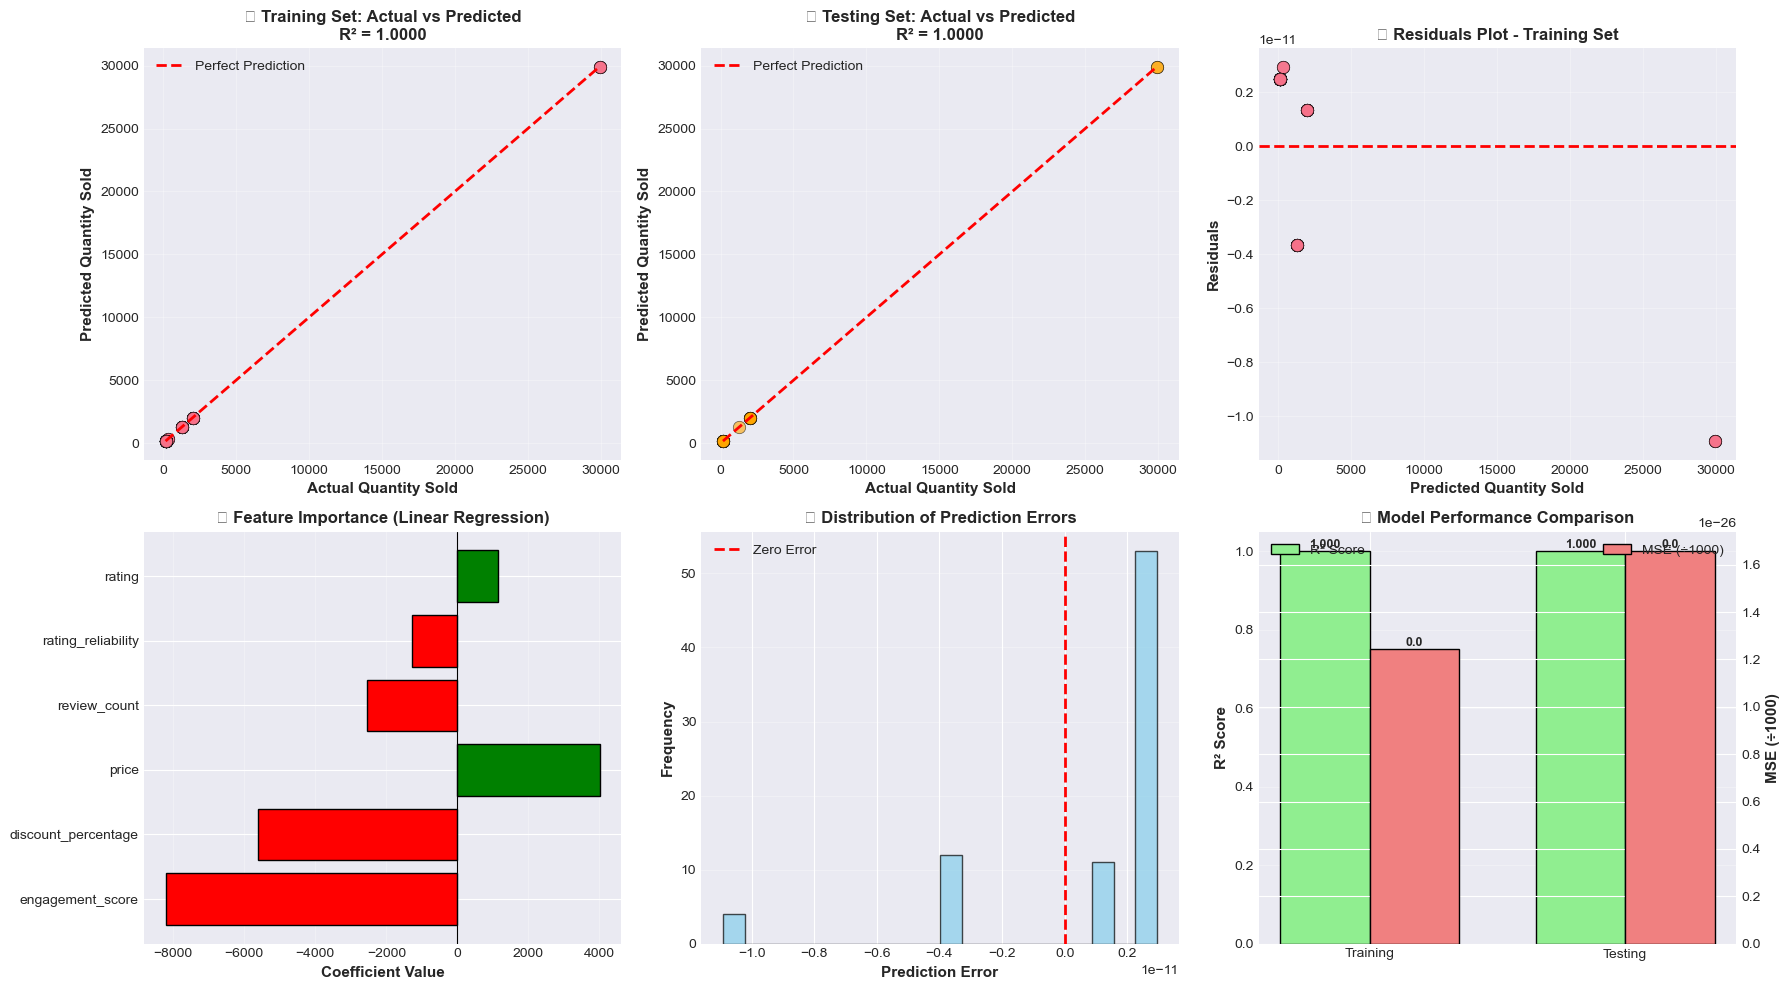

In [ ]:
# Visualize Linear Regression Results - Cho tất cả biến phụ thuộc
fig = plt.figure(figsize=(20, 5 * len(dependent_features)))

plot_idx = 1

for target_feature in dependent_features:
    result = regression_results[target_feature]
    
    train_r2 = result['train_r2']
    test_r2 = result['test_r2']
    train_mse = result['train_mse']
    test_mse = result['test_mse']
    y_train = result['y_train']
    y_test = result['y_test']
    y_train_pred = result['y_train_pred']
    y_test_pred = result['y_test_pred']
    feature_importance = result['feature_importance']
    
    # 1. Actual vs Predicted - Training Set
    ax1 = plt.subplot(len(dependent_features), 4, plot_idx)
    ax1.scatter(y_train, y_train_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=80, color='blue')
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
    ax1.set_xlabel(f'Actual {target_feature}', fontsize=10, fontweight='bold')
    ax1.set_ylabel(f'Predicted {target_feature}', fontsize=10, fontweight='bold')
    ax1.set_title(f'📊 {target_feature}: Train R²={train_r2:.3f}', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Actual vs Predicted - Testing Set
    ax2 = plt.subplot(len(dependent_features), 4, plot_idx + 1)
    ax2.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='black', linewidth=0.5, s=80, color='orange')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
    ax2.set_xlabel(f'Actual {target_feature}', fontsize=10, fontweight='bold')
    ax2.set_ylabel(f'Predicted {target_feature}', fontsize=10, fontweight='bold')
    ax2.set_title(f'📊 {target_feature}: Test R²={test_r2:.3f}', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # 3. Feature Importance
    ax3 = plt.subplot(len(dependent_features), 4, plot_idx + 2)
    colors_fi = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
    bars = ax3.barh(feature_importance['Feature'], feature_importance['Coefficient'], 
                    color=colors_fi, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Coefficient Value', fontsize=10, fontweight='bold')
    ax3.set_title(f'📊 {target_feature}: Feature Importance', fontsize=11, fontweight='bold')
    ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Model Performance Comparison
    ax4 = plt.subplot(len(dependent_features), 4, plot_idx + 3)
    x_pos = np.arange(2)
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, [train_r2, test_r2], width, 
                    label='R² Score', color='lightgreen', edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('R² Score', fontsize=10, fontweight='bold')
    ax4.set_title(f'📊 {target_feature}: Performance', fontsize=11, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(['Training', 'Testing'])
    ax4.legend(loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for bar in bars1:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plot_idx += 4

plt.tight_layout()
plt.show()

print("\n✅ Đã tạo biểu đồ cho tất cả biến phụ thuộc!")